In [1]:
import os
import json
from mathutils import Matrix
import numpy as np
from scipy.spatial.transform import Rotation

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [2]:
# Specify the path to the dataset folder
dataset_path = 'data/3RScan'

scenes = {}

for scan_folder in os.listdir(dataset_path):
    scan_folder_path = os.path.join(dataset_path, scan_folder)

    # Check if the folder contains semseg.v2.json file
    semseg_file = os.path.join(scan_folder_path, 'semseg.v2.json')
    if not os.path.isfile(semseg_file):
        continue

    # Read and parse the semseg.v2.json file
    with open(semseg_file, 'r') as file:
        semseg_data = json.load(file)

    scan_id = semseg_data['scan_id']
    seg_groups = semseg_data['segGroups']
    
    extracted_objects = []

    # Extract individual objects
    for object_data in seg_groups:
        obj = {}
        # Extract necessary data from JSON
        axes_lengths = object_data['obb']['axesLengths']
        centroid = object_data['obb']['centroid']
        normalized_axes = object_data['obb']['normalizedAxes']
        rotation_matrix = np.transpose(np.array(normalized_axes).reshape(3, 3))
        
        rotation = Rotation.from_matrix(rotation_matrix)
        euler_angles = rotation.as_euler('xyz', degrees=False) # degrees in radians
        
        # faking it: align the rotations hardcoding
        comparison_angles = [0.698, 2.269]
        differences = np.abs(euler_angles[2] - comparison_angles)
        closest_index = np.argmin(differences)
        euler_angles[2] = comparison_angles[closest_index]
        
        # Print the extracted data for each object
        obj['id'] = object_data['objectId']
        obj['label'] = object_data['label']
        obj['location'] = centroid
        obj['size'] = axes_lengths
        obj['euler_angles'] = euler_angles

        extracted_objects.append(obj)
    
    scenes[scan_id] = extracted_objects

### Analysis of a single unfiltered scene

In [3]:
scan_id = '4acaebcc-6c10-2a2a-858b-29c7e4fb410d'
#scan_id = '754e884c-ea24-2175-8b34-cead19d4198d'

# number of objects in scene
total_objects = len(scenes[scan_id])
print("Total objects:", total_objects)
print('---')

# Create an empty dictionary to store label counts
label_counts = {}

# Count the occurrences of each label
for item in scenes[scan_id]:
    label = item['label']
    if label in label_counts:
        label_counts[label] += 1
    else:
        label_counts[label] = 1

# Print the label counts
for label, count in label_counts.items():
    print(label, count)

Total objects: 32
---
beanbag 2
table 1
cushion 3
sofa 1
tv 1
commode 1
ceiling 1
plant 6
window 4
light 2
floor 1
wall 3
windowsill 1
shades 3
heater 1
trash can 1


### Analysis of all unfiltered scenes

[31, 32]


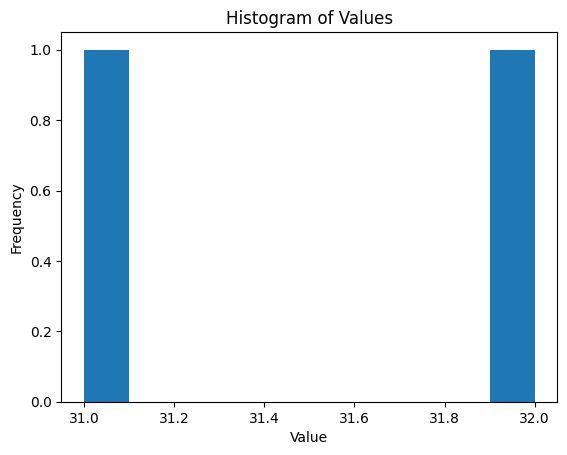

In [6]:
total_objects = []
for scan_id in scenes:
    total_objects.append(len(scenes[scan_id]))
print(total_objects)

# Create a histogram
plt.hist(total_objects, bins=10)  # Specify the number of bins or customize as needed

# Set labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values')

# Display the histogram
plt.show()

## Filtering Scenes

In [20]:
filtered_scenes = {}
for scan_id in scenes:
    
    # Filter out objects with specified labels
    labels_to_remove = ['ceiling', 'wall', 'floor', 'plant', 'window', 'windowsill', 'shades']
    filtered_scenes[scan_id] = [obj for obj in scenes[scan_id] if obj['label'] not in labels_to_remove]
    
    # Filter out objects, if we have too many
    limit = 20
    filtered_scenes[scan_id] = filtered_scenes[scan_id][:20]


### Analysis of a single filtered scene

In [21]:
scan_id = '4acaebcc-6c10-2a2a-858b-29c7e4fb410d'
#scan_id = '754e884c-ea24-2175-8b34-cead19d4198d'

total_objects = len(filtered_scenes[scan_id])
print("Total objects:", total_objects)
print('---')

# Create an empty dictionary to store label counts
label_counts = {}

# Count the occurrences of each label
for item in filtered_scenes[scan_id]:
    label = item['label']
    if label in label_counts:
        label_counts[label] += 1
    else:
        label_counts[label] = 1

# Print the label counts
for label, count in label_counts.items():
    print(label, count)

Total objects: 13
---
beanbag 2
table 1
cushion 3
sofa 1
tv 1
commode 1
light 2
heater 1
trash can 1


### Plot a single filtered Scene

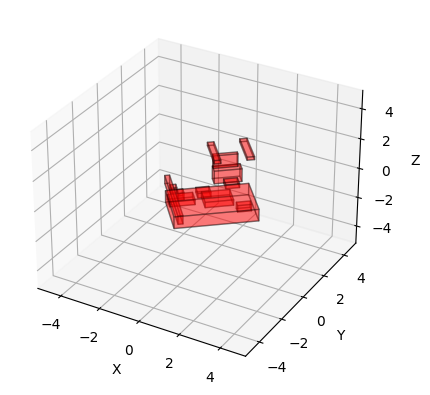

In [23]:
scan_id = '4acaebcc-6c10-2a2a-858b-29c7e4fb410d'
#scan_id = '754e884c-ea24-2175-8b34-cead19d4198d'

# Create a 3D plot
fig1 = plt.figure()
ax = fig1.add_subplot(111, projection='3d')

# Visualize objects in the scene
for object_data in filtered_scenes[scan_id]:

    # Extract necessary data from the object
    location = object_data['location']
    size = object_data['size']
    euler_angles = object_data['euler_angles']
    
    rotation = Rotation.from_euler('xyz', euler_angles)
    rotation_matrix = rotation.as_matrix()
        

    # Compute half-lengths along each axis
    half_lengths = np.array(size) / 2

    # Define relative coordinates of object's corners in local frame
    corners = np.array([
        [-1, -1, -1],  # Corner 1
        [-1, -1, 1],   # Corner 2
        [-1, 1, -1],   # Corner 3
        [-1, 1, 1],    # Corner 4
        [1, -1, -1],   # Corner 5
        [1, -1, 1],    # Corner 6
        [1, 1, -1],    # Corner 7
        [1, 1, 1]      # Corner 8
    ])
    scaled_corners = corners * half_lengths
    relative_corners = np.transpose(scaled_corners)

    relative_corners_4 = np.vstack((relative_corners, np.ones(relative_corners.shape[1])))

    transformation_matrix = np.eye(4)
    transformation_matrix[:3, :3] = rotation_matrix
    transformation_matrix[:3, 3] = location

    global_corners_4 = np.matmul(transformation_matrix, relative_corners_4)
    global_corners = np.transpose(global_corners_4[:3, :])
    
    polygons = [
        [global_corners[0], global_corners[1], global_corners[3], global_corners[2]],
        [global_corners[4], global_corners[5], global_corners[7], global_corners[6]],
        [global_corners[0], global_corners[1], global_corners[5], global_corners[4]],
        [global_corners[2], global_corners[3], global_corners[7], global_corners[6]],
        [global_corners[0], global_corners[2], global_corners[6], global_corners[4]],
        [global_corners[1], global_corners[3], global_corners[7], global_corners[5]]
    ]
    
    # Create the 3D collection and add it to the plot
    collection = Poly3DCollection(polygons, alpha=0.3, facecolor='red', edgecolor='black')
    ax.add_collection3d(collection)
    

# Set labels for the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set the limits of the plot's axes
factor = 5
x_min, x_max, y_min, y_max, z_min, z_max = -factor, factor, -factor, factor, -factor, factor
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_zlim(z_min, z_max)

# Show the plot
plt.show()

## Analysis of all filtered scenes

[12, 13]


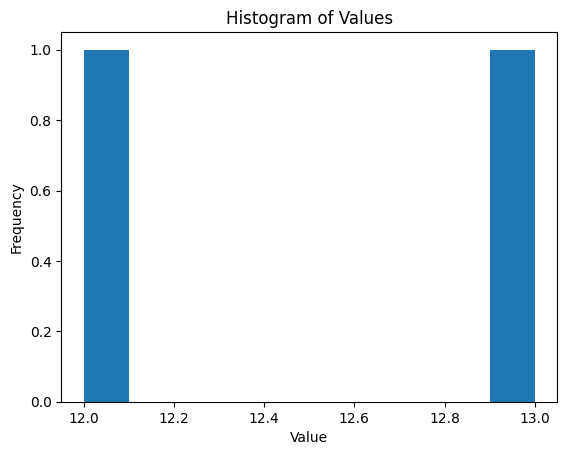

In [12]:
total_objects = []
for scan_id in filtered_scenes:
    total_objects.append(len(filtered_scenes[scan_id]))
print(total_objects)

# Create a histogram
plt.hist(total_objects, bins=10)  # Specify the number of bins or customize as needed

# Set labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values')

# Display the histogram
plt.show()

In [13]:
# Create Scene Matrix Data

In [17]:
scene_matrices = {}
for scene_id in filtered_scenes:
    # Extract values from the dataset
    locations = np.array([obj['location'] for obj in filtered_scenes[scene_id]])
    euler_angles = np.array([obj['euler_angles'] for obj in filtered_scenes[scene_id]])
    sizes = np.array([obj['size'] for obj in filtered_scenes[scene_id]])

    # Create the matrix
    stacked_matrix = np.hstack((locations, euler_angles, sizes))
    
    # Determine the desired number of rows
    desired_rows = 20

    # Add rows of zeros to each matrix
    scene_matrices[scene_id] = np.pad(stacked_matrix, [(0, desired_rows - stacked_matrix.shape[0]), (0, 0)], mode='constant')


In [19]:
print(scene_matrices['4acaebcc-6c10-2a2a-858b-29c7e4fb410d'])

[[-6.84807930e-01  1.50600814e+00 -1.43351997e+00  1.57079633e+00
   0.00000000e+00  6.98000000e-01  5.99779988e-01  3.12960022e-01
   5.52739879e-01]
 [ 4.28866204e-04  2.87150392e+00 -1.46279992e+00  1.57079633e+00
   0.00000000e+00  6.98000000e-01  6.29363824e-01  2.65539998e-01
   5.52159044e-01]
 [ 1.59102539e-01  1.30160039e+00 -1.40811492e+00  1.57079633e+00
   0.00000000e+00  6.98000000e-01  1.28660188e+00  3.64070050e-01
   9.38190336e-01]
 [ 1.67562932e+00  9.85771849e-01 -1.14593993e+00  1.57079633e+00
   0.00000000e+00  6.98000000e-01  6.26836042e-01  4.31879928e-01
   3.09504442e-01]
 [-1.05515146e+00  1.73084350e-01 -1.19090493e+00  1.57079633e+00
   0.00000000e+00  6.98000000e-01  1.14280790e+00  3.21810000e-01
   6.74080726e-01]
 [ 3.70007829e-01  4.24366445e-01 -1.22058992e+00  1.57079633e+00
   0.00000000e+00  6.98000000e-01  3.76698588e+00  7.81179947e-01
   2.31833107e+00]
 [-1.15614385e+00  2.99860493e-01 -9.66616980e-01  1.57079633e+00
  -2.22044605e-16  2.2690000